# 6.3 Build/Select Appropriate Model(s)

In [1]:
import pyspark
from pyspark.sql.functions import col, count, isnan, when
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("PySpark in Jupyter") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 06:52:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/23 06:52:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# One with dementia one without dementia
df = spark.read.csv('Dataset/df_new_6d.csv', header=True, inferSchema=True)
df2 = spark.read.csv('Dataset/df_new_6wd.csv', header=True, inferSchema=True)

# Feature Selection

In [3]:
# Identify string columns
string_columns = [field.name for field in df.schema.fields if str(field.dataType) == 'StringType']

# Step 1: Convert string columns to numerical using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in string_columns]

# Apply StringIndexer to create indexed DataFrame
df_indexed = df
for indexer in indexers:
    df_indexed = indexer.transform(df_indexed)

# Step 2: Assemble features into a single vector column
indexed_columns = [column+"_index" if column in string_columns else column for column in df.columns if column != 'target_column']  # Exclude the target column
vector_assembler = VectorAssembler(inputCols=indexed_columns, outputCol="features")

# Step 3: Create a Random Forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="Dementia", numTrees=100)

# Step 4: Create a Pipeline to chain indexers and classifier
stages = indexers + [vector_assembler, rf]
pipeline = Pipeline(stages=stages)

# Step 5: Fit the pipeline to the data
model = pipeline.fit(df)

# Step 6: Extract feature importance
rf_model = model.stages[-1]
feature_importance = rf_model.featureImportances.toArray()

# Create a dictionary to store feature importance scores
feature_importance_dict = {indexed_columns[i]: feature_importance[i] for i in range(len(indexed_columns))}

# Sort feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importance scores in a nice table format
print("{:<30} {:<20}".format("Feature", "Importance Score"))
print("-" * 50)
for feature, score in sorted_feature_importance:
    print("{:<30} {:<20}".format(feature, round(score, 4)))



Feature                        Importance Score    
--------------------------------------------------
Cognitive_Test_Scores          0.4447              
Dementia                       0.4063              
Depression_Status_index        0.0894              
APOE_ε4_index                  0.0428              
Smoking_Status_index           0.0099              
Age                            0.0017              
Family_History_index           0.0017              
Weight                         0.0014              
BodyTemperature                0.001               
MRI_Delay                      0.0003              
AlcoholLevel                   0.0002              
Education_Group_index          0.0002              
Education_Level_index          0.0002              
HeartRate                      0.0002              


# Clustering

In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Identify categorical columns
categorical_columns = [col for col, dtype in df.dtypes if dtype == "string"]

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed") for column in categorical_columns]
encoders = [OneHotEncoder(inputCol=column+"_indexed", outputCol=column+"_encoded") for column in categorical_columns]

# Apply indexers and encoders
pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(df).transform(df)

# Drop original categorical columns and indexed columns
for column in categorical_columns:
    df_encoded = df_encoded.drop(column).drop(column+"_indexed")

# Show the transformed DataFrame
df_encoded.show(5)


+------------+---------+---------------+------+---------+----+---------------------+--------+-----------------------+----------------------+----------------------+---------------+-------------------------+-----------------------+
|AlcoholLevel|HeartRate|BodyTemperature|Weight|MRI_Delay| Age|Cognitive_Test_Scores|Dementia|Education_Level_encoded|Family_History_encoded|Smoking_Status_encoded|APOE_ε4_encoded|Depression_Status_encoded|Education_Group_encoded|
+------------+---------+---------------+------+---------+----+---------------------+--------+-----------------------+----------------------+----------------------+---------------+-------------------------+-----------------------+
|        0.11|    123.0|          36.68| 66.59|    21.15|67.0|                  1.0|     1.0|          (2,[1],[1.0])|             (1,[],[])|         (2,[0],[1.0])|  (1,[0],[1.0])|                (1,[],[])|          (1,[0],[1.0])|
|        0.02|     90.0|          37.02| 83.98|    11.35|87.0|                  

In [5]:
from pyspark.ml.feature import VectorAssembler

# List all feature columns
feature_columns = [col for col in df_encoded.columns if col != "label_column_name"]  # Exclude label column if you have one

# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the DataFrame to include the features column
df_features = vector_assembler.transform(df_encoded)

# Show the new DataFrame with the features column
df_features.select("features").show(5, truncate=False)


+---------------------------------------------------------------------------+
|features                                                                   |
+---------------------------------------------------------------------------+
|[0.11,123.0,36.68,66.59,21.15,67.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0]|
|[0.02,90.0,37.02,83.98,11.35,87.0,7.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0] |
|[0.16,35.0,36.05,69.65,30.34,66.0,9.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0] |
|[0.1,64.0,36.4,58.37,49.18,87.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0]   |
|[0.07,97.0,37.12,81.58,22.28,73.0,9.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0] |
+---------------------------------------------------------------------------+
only showing top 5 rows



24/05/23 06:52:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
from pyspark.ml.clustering import KMeans

# Define the KMeans algorithm with a specified number of clusters
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="prediction")  # Adjust 'k' as needed

# Fit the KMeans model
kmeans_model = kmeans.fit(df_features)

# Make predictions (assign clusters)
df_clustered = kmeans_model.transform(df_features)

# Show the clustered DataFrame with predictions
df_clustered.select("features", "prediction").show(5, truncate=False)


+---------------------------------------------------------------------------+----------+
|features                                                                   |prediction|
+---------------------------------------------------------------------------+----------+
|[0.11,123.0,36.68,66.59,21.15,67.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0]|1         |
|[0.02,90.0,37.02,83.98,11.35,87.0,7.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0] |1         |
|[0.16,35.0,36.05,69.65,30.34,66.0,9.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0] |0         |
|[0.1,64.0,36.4,58.37,49.18,87.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0]   |0         |
|[0.07,97.0,37.12,81.58,22.28,73.0,9.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0] |1         |
+---------------------------------------------------------------------------+----------+
only showing top 5 rows



In [7]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette = evaluator.evaluate(df_clustered)
print("Silhouette with squared Euclidean distance = " + str(silhouette))


Silhouette with squared Euclidean distance = 0.3634281280925444


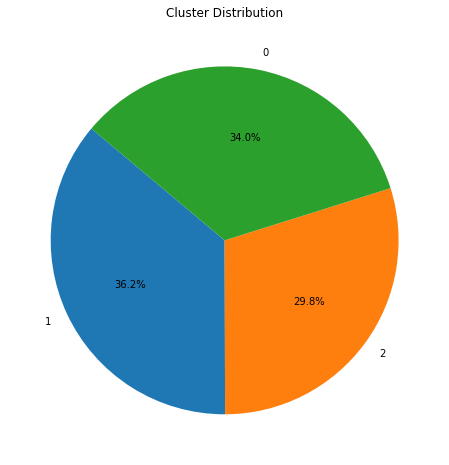

In [8]:
import matplotlib.pyplot as plt

# Get the count of each cluster
cluster_counts = df_clustered.groupBy("prediction").count().collect()
cluster_counts_dict = {row['prediction']: row['count'] for row in cluster_counts}

# Plot pie chart for cluster distribution
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts_dict.values(), labels=cluster_counts_dict.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Cluster Distribution")
plt.show()


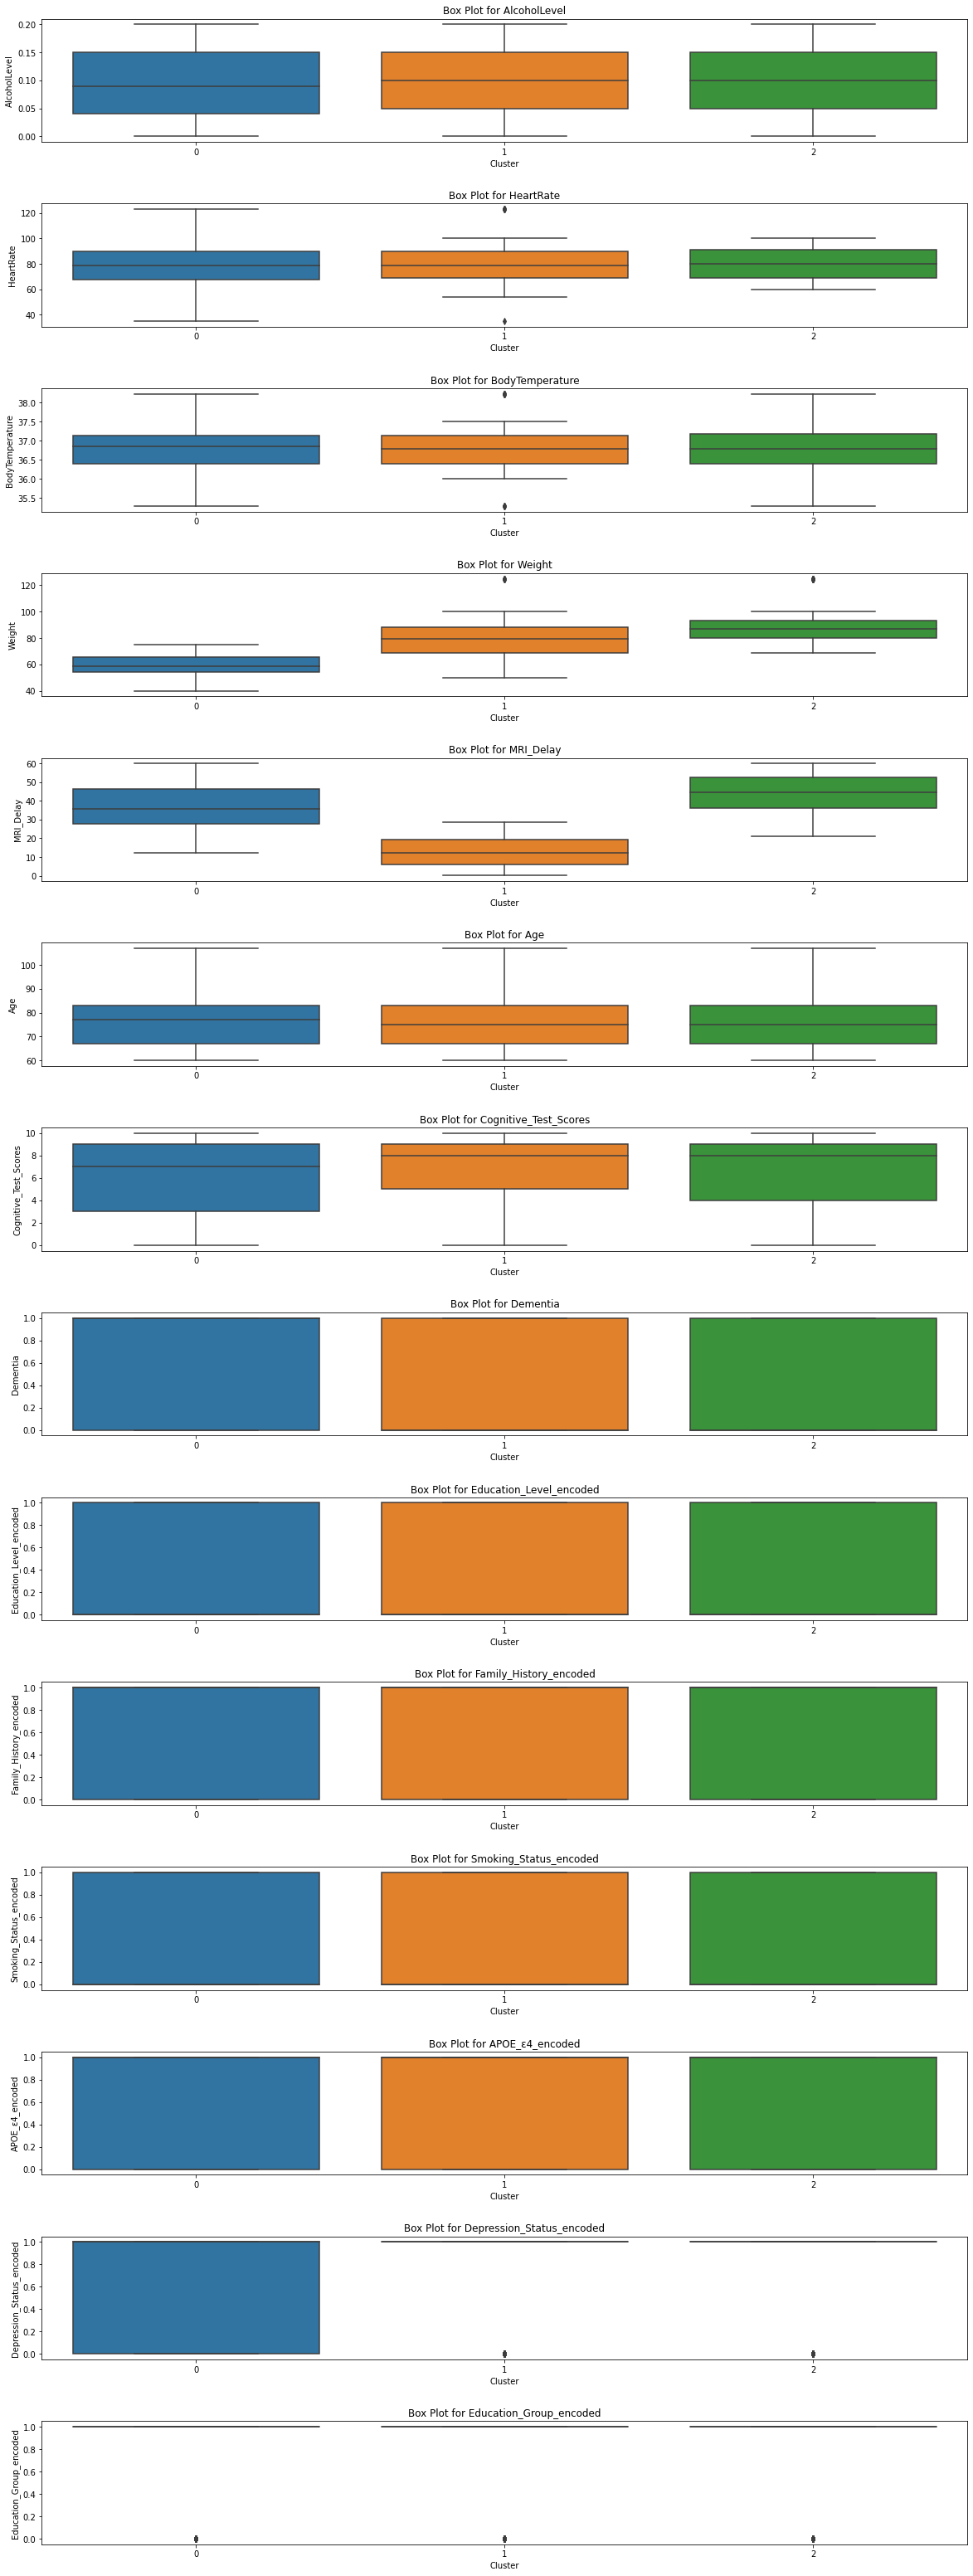

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.linalg import SparseVector

# Get the variables to plot
variables = [col for col in df_clustered.columns if col not in ['features', 'prediction']]

# Create a figure for box plots
plt.figure(figsize=(20, len(variables) * 4))

# Plot box plot for each variable
for idx, var in enumerate(variables):
    # Gather data for the current variable and clusters
    plot_data = [(row['prediction'], row[var]) for row in df_clustered.select("prediction", var).collect()]
    cluster_labels, var_values = zip(*plot_data)

    # Convert cluster labels to numeric
    cluster_labels = [int(label) for label in cluster_labels]

    # Extract the numeric values from SparseVector
    var_values_numeric = [value.toArray()[0] if isinstance(value, SparseVector) else value for value in var_values]

    # Convert var_values to numeric if possible
    try:
        var_values_numeric = [float(value) for value in var_values_numeric]
    except ValueError:
        print(f"Skipping {var} due to non-numeric data")
        continue

    # Create a subplot for the current variable
    plt.subplot(len(variables), 1, idx + 1)
    sns.boxplot(x=cluster_labels, y=var_values_numeric)
    plt.title(f"Box Plot for {var}")
    plt.xlabel("Cluster")
    plt.ylabel(var)

# Adjust layout to provide more space between subplots
plt.subplots_adjust(hspace=0.5)

# Show plot
plt.show()


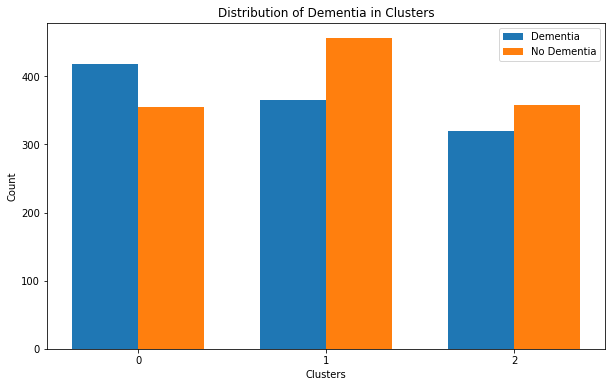

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Group the data by 'prediction' and 'Dementia' and count the occurrences
cluster_dementia_counts = df_clustered.groupBy("prediction", "Dementia").count().collect()

# Prepare data for plotting
cluster_data = {}
for row in cluster_dementia_counts:
    cluster = row['prediction']
    dementia_status = 'Dementia' if row['Dementia'] == 1 else 'No Dementia'
    count = row['count']
    if cluster not in cluster_data:
        cluster_data[cluster] = {'Dementia': 0, 'No Dementia': 0}
    cluster_data[cluster][dementia_status] = count  # Set counts directly

# Sort the cluster data by keys (clusters)
cluster_data = dict(sorted(cluster_data.items()))

# Extract data for plotting
clusters = list(cluster_data.keys())
dementia_counts = [cluster_data[cluster].get('Dementia', 0) for cluster in clusters]  # Get count or default to 0
no_dementia_counts = [cluster_data[cluster].get('No Dementia', 0) for cluster in clusters]  # Get count or default to 0

# Plot the distribution graph with bars side by side
bar_width = 0.35
index = np.arange(len(clusters))  # Use numpy to create evenly spaced x-coordinates
plt.figure(figsize=(10, 6))
plt.bar(index, dementia_counts, bar_width, label='Dementia')
plt.bar(index + bar_width, no_dementia_counts, bar_width, label='No Dementia')
plt.xlabel('Clusters')
plt.ylabel('Count')
plt.title('Distribution of Dementia in Clusters')
plt.xticks(index + bar_width / 2, clusters)  # Adjust x-ticks to center bars
plt.legend()
plt.show()


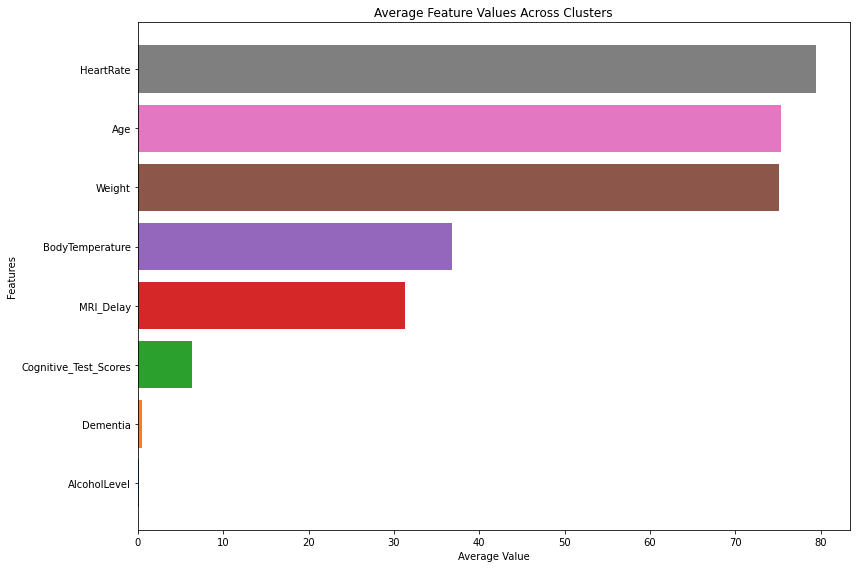

In [11]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Filter out non-numeric columns from feature_columns
numeric_feature_columns = [col for col in feature_columns if col not in ['Education_Level_encoded', 'Family_History_encoded', 'Smoking_Status_encoded', 'APOE_ε4_encoded', 'Depression_Status_encoded','Education_Group_encoded']]

# Compute the average value of each feature within each cluster
average_feature_values = df_clustered.groupBy("prediction").avg(*numeric_feature_columns)

# Extract the average values as a list of dictionaries
average_values_list = average_feature_values.collect()

# Create a dictionary to store average feature values for each cluster
average_feature_values_dict = {row['prediction']: row for row in average_values_list}

# Create a list to store feature names
feature_names = numeric_feature_columns

# Create a list to store average values for each cluster
average_values_by_feature = [[] for _ in range(len(numeric_feature_columns))]

# Iterate over feature columns and clusters to populate the lists
for idx, feature_col in enumerate(numeric_feature_columns):
    for cluster in range(len(average_values_list)):
        average_values_by_feature[idx].append(average_feature_values_dict[cluster][f"avg({feature_col})"])

# Calculate the total average value for each feature
total_average_values = [sum(values) / len(average_values_list) for values in average_values_by_feature]

# Sort the features based on their total average values
sorted_features = sorted(zip(feature_names, total_average_values), key=lambda x: x[1], reverse=True)

# Reverse the order to have the most important features at the top
sorted_features.reverse()

# Plot the bar chart
plt.figure(figsize=(12, 8))
for feature_name, feature_values in sorted_features:
    plt.barh(feature_name, feature_values)

plt.title('Average Feature Values Across Clusters')
plt.xlabel('Average Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [16]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Create a ClusteringEvaluator instance
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction')

# Evaluate clustering by computing Silhouette score
silhouette_score = evaluator.evaluate(df_clustered)
print("Silhouette Score:", silhouette_score)


Silhouette Score: 0.3634281280925444


# Regression

In [12]:
# Manually select the columns you want to keep
selected_columns = ['Education_Level_index', 'Family_History_index', 'Smoking_Status_index', 'APOE_ε4_index', 'Depression_Status_index', 'Education_Group_index']

# Select the desired columns from the DataFrame
df = df.drop(*selected_columns)
df2 = df2.drop(*selected_columns)

In [13]:
def spark_info(df):
    # Get the schema of the DataFrame
    schema = df.schema
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = df.filter(col(column_name).isNotNull()).count()
        
        # Count null values
        null_count = df.filter(col(column_name).isNull() | isnan(col(column_name))).count()
        
        columns_info.append((column_name, column_type, non_null_count, null_count))
    
    # Display the DataFrame schema and summary
    total_rows = df.count()
    total_columns = len(schema)
    
    # Print the summary table
    print(f"DataFrame Summary:")
    print(f"{'Total Rows':<15}: {total_rows}")
    print(f"{'Total Columns':<15}: {total_columns}")
    print("\nDataFrame Schema:")
    print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
    print("-" * 60)
    for column_info in columns_info:
        print(f"{column_info[0]:<25} {column_info[2]:<15} {column_info[3]:<10} {column_info[1]:<10}")

# Call the function to describe the DataFrame
spark_info(df)

DataFrame Summary:
Total Rows     : 2271
Total Columns  : 14

DataFrame Schema:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
AlcoholLevel              2271            0          double    
HeartRate                 2271            0          double    
BodyTemperature           2271            0          double    
Weight                    2271            0          double    
MRI_Delay                 2271            0          double    
Age                       2271            0          double    
Education_Level           2271            0          string    
Family_History            2271            0          string    
Smoking_Status            2271            0          string    
APOE_ε4                   2271            0          string    
Depression_Status         2271            0          string    
Cognitive_Test_Scores     2271            0          double    
Dementia                  2

In [14]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import GBTRegressor

# Define categorical and numerical columns
categorical_cols = [col for col, dtype in df.dtypes if dtype == "string"]
numerical_cols = [col for col in df.columns if col not in categorical_cols]

# Index categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep").fit(df) for col in categorical_cols]

# Assemble indexed categorical columns and numerical columns into features
assembler = VectorAssembler(inputCols=numerical_cols + [col_name+"_index" for col_name in categorical_cols],
                            outputCol="features")

# Transforming the DataFrame with indexers and assembler
df_indexed = df
for indexer in indexers:
    df_indexed = indexer.transform(df_indexed)

df_features = assembler.transform(df_indexed)

# Define your GBTRegressor model
gbt = GBTRegressor(featuresCol="features", labelCol="Dementia")  # You may need to adjust parameters

# Train the model
model = gbt.fit(df_features)

# Make predictions
predictions = model.transform(df_features)



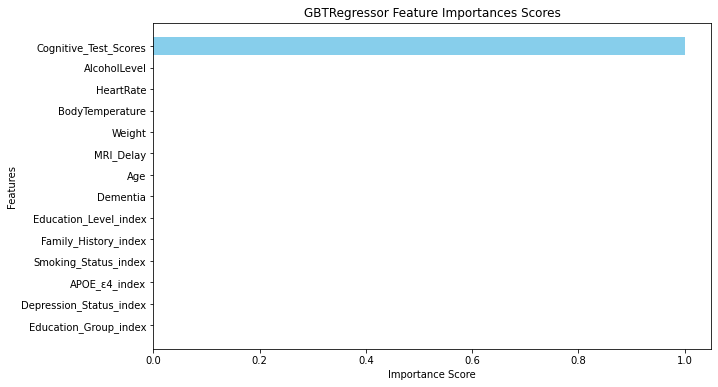

In [15]:
# Get feature importances
importance_df = model.featureImportances

# Get feature names
feature_names = numerical_cols + [col_name+"_index" for col_name in categorical_cols]

# Zip feature names with importances and convert to list of tuples
feature_importances = list(zip(feature_names, importance_df))

# Sort feature importances by importance score (in descending order)
feature_importances_sorted = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Extract sorted feature names and importances
sorted_feature_names = [x[0] for x in feature_importances_sorted]
sorted_importances = [x[1] for x in feature_importances_sorted]

# Plotting the feature importances with the most important variable at the top
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('GBTRegressor Feature Importances Scores')
plt.gca().invert_yaxis()  # Reverse the y-axis to have the most important variable at the top
plt.show()
